## <u> Ocular Cataract Intelligent Recognition (OCIR) </u>

<i>Leveraging the power of Deep Learning, our trained Convolutional Neural Network(CNN) model aims to detect one of the most common ocular conditions- Cataract.</i>

<u><i>Project Team:</i></u>
1. Joshua S Raju 22BAI1213
3. Shubham Yadav 22BAI1427
2. Md Rameez Haider 22BRS1327
   

<b><u>DISCLAIMER:</b></u> <i>While our CNN model aids in cataract detection, it is not a substitute for professional medical advice. Please consult a qualified healthcare provider for a comprehensive eye examination and diagnosis.</i>


<b>DATASET:</b>
https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
https://www.kaggle.com/datasets/jr2ngb/cataractdataset

## Importing Dependencies

In [1]:
import numpy as np
import os

import cv2
import matplotlib.pylab as plt
import imghdr

import tensorflow as tf

Tensorflow GPU Management 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Cleaning Image Data

In [3]:
data_dir = 'imgdata_v3'

## Creating Image Dataset

In [4]:
dataset = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256))

Found 7437 files belonging to 2 classes.


In [5]:
batch = dataset.as_numpy_iterator().next()
len(batch)

2

In [6]:
classes = ['cataract', 'normal']
classes

['cataract', 'normal']

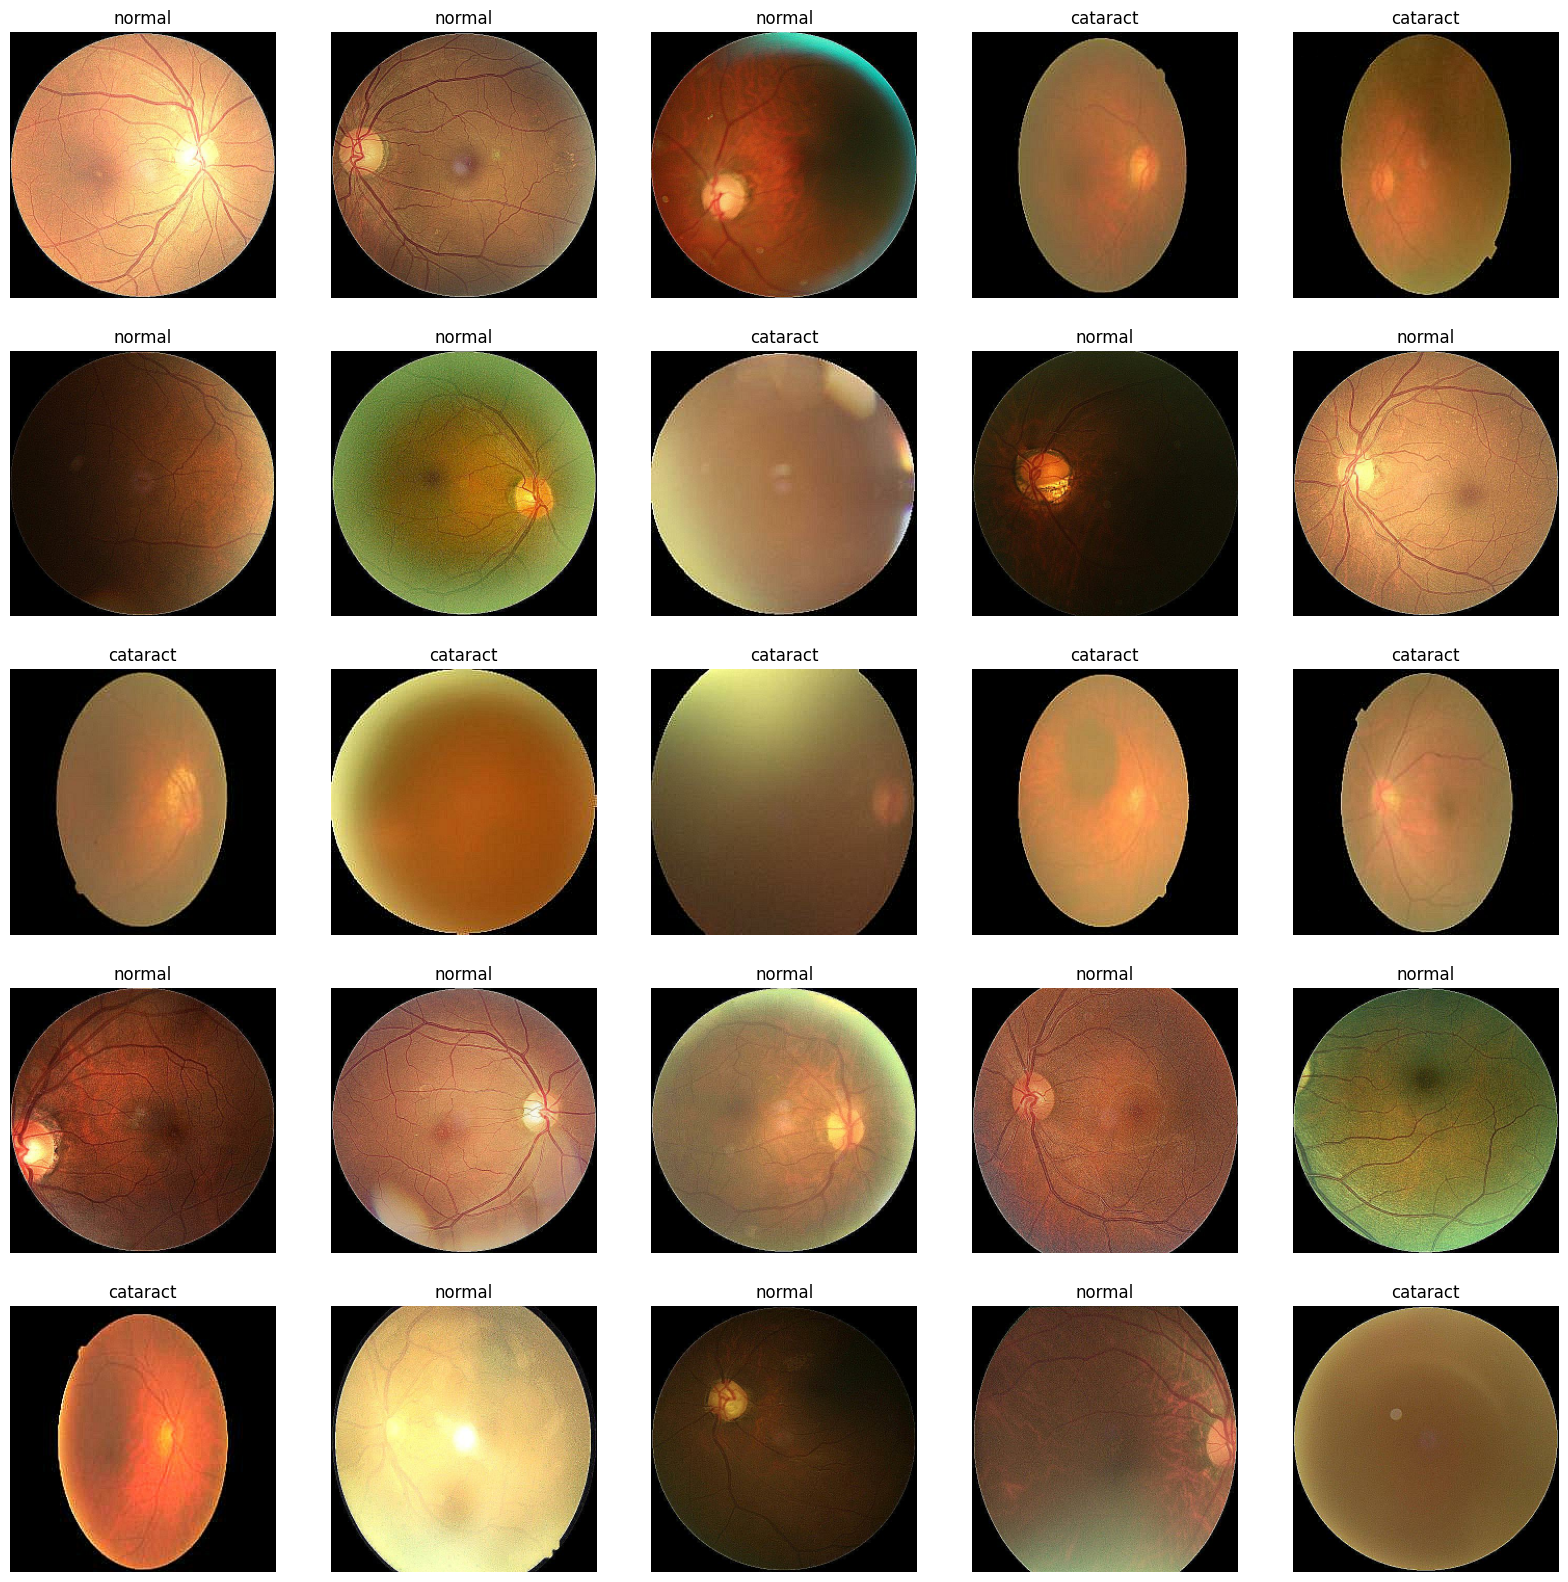

In [7]:
fig, axs = plt.subplots(5,5, figsize=(20,20))
for idx, img in enumerate(batch[0][:25]):
    row = idx//5
    col = idx%5

    axs[row, col].imshow(img.astype(int))
    axs[row, col].axis('off')
    axs[row, col].set_title(classes[batch[1][idx]])

## Scaling Dataset

In [8]:
batch[0][0].shape, batch[0][0].max(), batch[0][0].min()

((256, 256, 3), 255.0, 0.0)

In [9]:
data = dataset.map(lambda x,y: (x/255, y))

In [10]:
print(data.as_numpy_iterator().next()[0][0].shape, 
    data.as_numpy_iterator().next()[0][0].max(), 
    data.as_numpy_iterator().next()[0][0].min())

(256, 256, 3) 1.0 0.0


## Splitting Dataset

In [11]:
len(data)

233

In [12]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*0.2)+1
test_size = int(len(data)*0.1)

train_size + val_size + test_size

233

In [13]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size+val_size).take(test_size)

## Training CNN Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [15]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, kernel_regularizer=l2(0.001), activation='linear'))

model.compile(optimizer='adam', loss='hinge', metrics='accuracy')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

In [16]:
logdir = 'LogDir'

try:
    os.mkdir(logdir)
except Exception as e:
    pass    

tfb_callback = tf.keras.callbacks.TensorBoard(logdir)

In [17]:
model_fit = model.fit(train_data, epochs=1, shuffle=True, validation_data=val_data, callbacks=[tfb_callback])

163/163 [==============================] - 15s 51ms/step - loss: 0.6392 - accuracy: 0.7109 - val_loss: 0.3728 - val_accuracy: 0.8697


## Model Performance

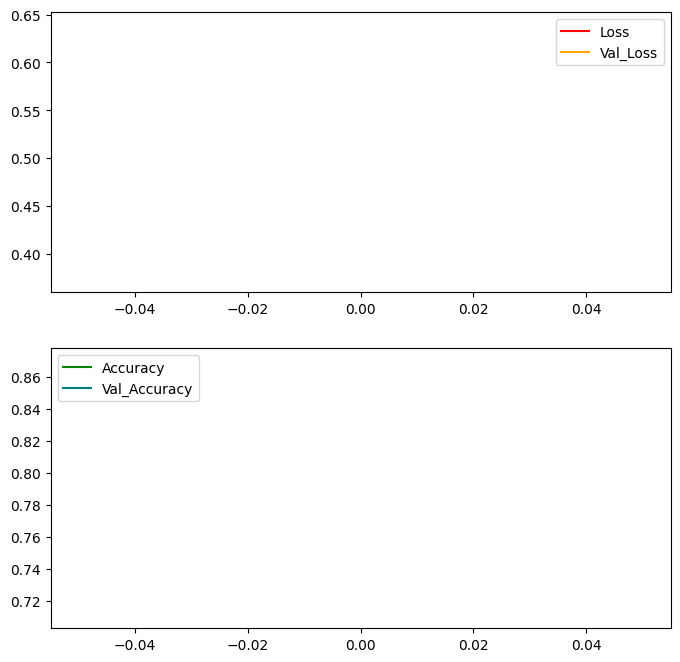

In [18]:
fig, axs = plt.subplots(2,1, figsize=(8,8))
axs[0].plot(model_fit.history['loss'], color='red', label='Loss')
axs[0].plot(model_fit.history['val_loss'], color='orange', label='Val_Loss')
axs[0].legend(loc='upper right')


axs[1].plot(model_fit.history['accuracy'], color='green', label='Accuracy')
axs[1].plot(model_fit.history['val_accuracy'], color='teal', label='Val_Accuracy')
axs[1].legend(loc='upper left')

## Evaluating Model

In [57]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, SpecificityAtSensitivity

In [58]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()
spe = SpecificityAtSensitivity(0.5)

In [59]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    pre.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    acc.update_state(y, y_pred)
    spe.update_state(y, y_pred)

1/1 [==============================] - 0s 25ms/step


In [61]:
precision = pre.result().numpy()
recall = rec.result().numpy()
f1 = 2 * (precision*recall) / (precision+recall)

print('Accuracy\t:', acc.result().numpy())
print('Precision\t:', precision)
print('Recall\t\t:', recall)
print('Specificity\t:', spe.result().numpy())
print('F1\t\t:', f1)

Accuracy	: 0.8661088
Precision	: 0.8376963
Recall		: 0.9039548
Specificity	: 0.9724518
F1		: 0.8695652054876281


## Exporting Model

In [23]:
model.save(os.path.join('models','ODIR_SVM.h5'))

In [24]:
from tensorflow.keras.models import load_model

In [25]:
new_model = load_model(os.path.join('models','ODIR_SVM.h5'))
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0